## Summary of the results

I have run 27 experiments, with different models, different batch sizes, etc. Most of them are in the `run_experiments.sh` file.

Let's have a look

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from plot_utils import highlight_greaterthan, build_model_df, plot_loss, plot_emb
from pathlib import Path

In [2]:
DATA_PATH = Path("../datasets/Amazon/models/")
fname = "results_df.p"

In [3]:
df_results = pd.read_pickle(DATA_PATH/fname)

These are the results, highlighting the row with the maximum `best_hr` and `best_ndcg` values (index 20). Note that in github the highlight will not appear. 

In [4]:
thresholds = [df_results.best_hr.max(), df_results.best_ndcg.max()]
columns = ['best_hr', 'best_ndcg']

In [5]:
(df_results
 .sort_values('modelname')
 .reset_index(drop=True)
 .style.apply(highlight_greaterthan, threshold=thresholds, column=columns, axis=1))

,modelname,iter_loss,best_hr,best_ndcg,best_iter,train_time
0,GMF_bs_1024_lr_0001_n_emb_8_lrnr_adam_lrs_wolrs.pt,0.271748,0.557995,0.346811,30,81.5565
1,GMF_bs_1024_lr_0005_n_emb_8_lrnr_adam_lrs_wolrs.pt,0.208753,0.685528,0.450089,28,81.6821
2,GMF_bs_1024_lr_001_n_emb_16_lrnr_adam_lrs_wolrs.pt,0.147244,0.686205,0.460785,30,84.9265
3,GMF_bs_1024_lr_001_n_emb_32_lrnr_adam_lrs_wolrs.pt,0.0956481,0.650702,0.435117,26,93.6193
4,GMF_bs_1024_lr_001_n_emb_64_lrnr_adam_lrs_wolrs.pt,0.054805,0.613295,0.406008,28,120.76
5,GMF_bs_1024_lr_001_n_emb_8_lrnr_adam_lrs_wlrs.pt,0.203959,0.695273,0.45934,30,84.5162
6,GMF_bs_1024_lr_001_n_emb_8_lrnr_adam_lrs_wolrs.pt,0.206089,0.709855,0.472012,28,88.3086
7,GMF_bs_1024_lr_001_n_emb_8_lrnr_adam_lrs_wolrs_loss_MSE.pt,0.0648755,0.682043,0.454177,20,81.5011
8,GMF_bs_512_lr_001_n_emb_8_lrnr_adam_lrs_wolrs_loss_MSE.pt,0.0663101,0.69065,0.451348,27,103.298
9,MLP_bs_1024_reg_00_lr_0001_n_emb_16_ll_8_dp_wodp_lrnr_adam_lrs_wolrs.pt,0.328461,0.55459,0.340501,22,90.4532


Let me just illustrate how the `modelname` should be read with a couple of examples:

* `GMF_bs_1024_lr_001_n_emb_16_lrnr_adam_lrs_wolrs.pt`: GMF model, trained with batch size of 1024, learning rate of 0.01, embeddings of 16 (latent) factors (or simply 16 dim embeddings), the learner (aka optimizer) is Adam and I have not used a learning rate scheduler (`lrs_wolrs`, as opposed to `lrs_wlrs`)

* `MLP_bs_1024_reg_00_lr_003_n_emb_32_ll_16_dp_wodp_lrnr_adam_lrs_wlrs.pt`: MLP model, trained with batch size of 1024, no L2 regularization, learning rate of 0.03, 32 dim embeddings, no dropout, trained with Adam optimizer and using learning rate scheduler (more precisely CyclicLR)

* `NeuMF_wpret_trainable_SGD_wo_momentum_lrs_wlrs.pt`: NeuMF model, trained with pretrained weights, using SGD with no momentum and using CyclicLR.

if you want more details, just go to the code :) .

### GMF and MLP

Let's grab the best performing models for the GMF and MLP cases

In [6]:
df_models = build_model_df(df_results)
df_models

,model,n_emb,modelname,iter_loss,best_hr,best_ndcg,best_iter,train_time
0,GMF,8,GMF_bs_1024_lr_001_n_emb_8_lrnr_adam_lrs_wolrs.pt,0.206089,0.709855,0.472012,28,88.308644
1,GMF,16,GMF_bs_1024_lr_001_n_emb_16_lrnr_adam_lrs_wolrs.pt,0.147244,0.686205,0.460785,30,84.926549
2,GMF,32,GMF_bs_1024_lr_001_n_emb_32_lrnr_adam_lrs_wolrs.pt,0.095648,0.650702,0.435117,26,93.619321
3,GMF,64,GMF_bs_1024_lr_001_n_emb_64_lrnr_adam_lrs_wolrs.pt,0.054805,0.613295,0.406008,28,120.759626
4,MLP,16,MLP_bs_1024_reg_00_lr_001_n_emb_16_ll_8_dp_wodp_lrnr_adam_lrs_wolrs.pt,0.197586,0.609697,0.396860,30,98.565004
5,MLP,32,MLP_bs_1024_reg_00_lr_003_n_emb_32_ll_16_dp_wodp_lrnr_adam_lrs_wolrs.pt,0.203978,0.637601,0.405437,30,95.000546
6,MLP,64,MLP_bs_1024_reg_00_lr_003_n_emb_64_ll_32_dp_wodp_lrnr_adam_lrs_wlrs.pt,0.205861,0.649072,0.435519,16,118.406985


Let's visualize the results

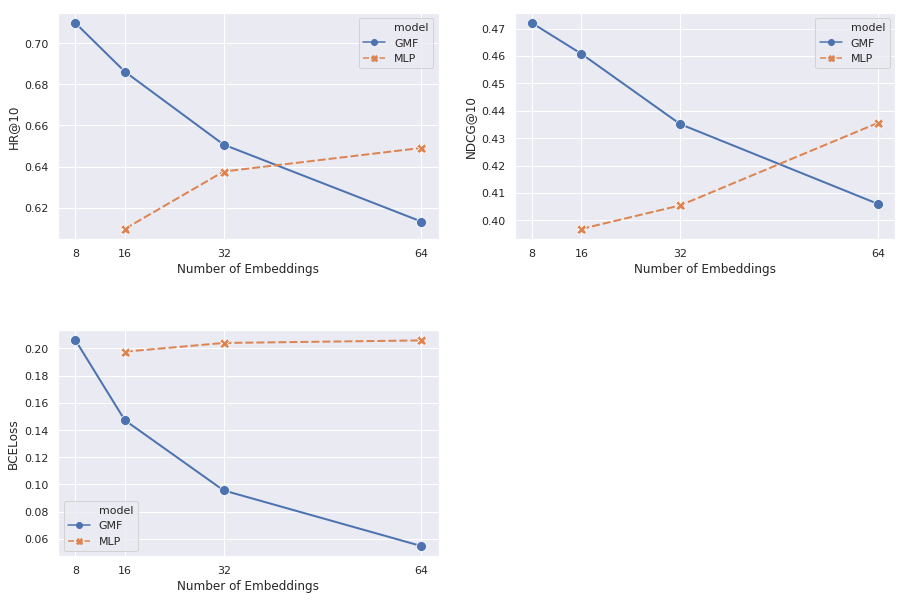

In [7]:
plot_emb(df_models)

I find these plots quite interesting. The upper plots show that in the case of the MLP model, the ranking metrics (i.e. HR@10 and NDCG@10 increase) improve as one uses embeddings of higher dimension which is perhaps the expected behaviour. However, the behaviour is the opposite in the case of the GMF model, where higher dimension embeddings lead to lower HR@10 and NDCG@10. 

On the other hand, the lower plot shows that while for the GMF model the loss (binary cross entropy, hereafter BCE) descreases as we use higher dimension embeddings, the opposite occurs for the MLP model. Let's further visualize the results in terms of ranking vs classifying metrics.

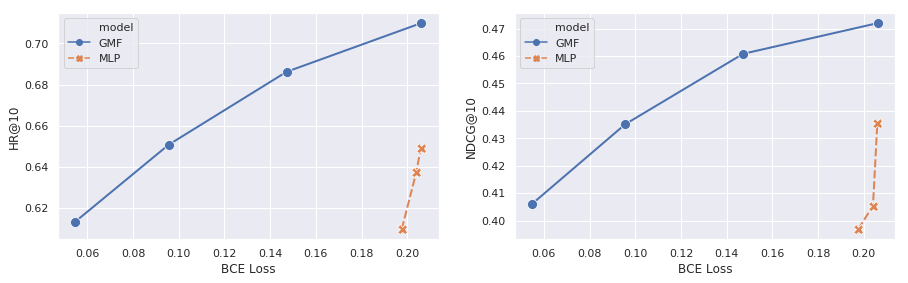

In [8]:
plot_loss(df_models)

Considering these plots altogether, we observe that, in the case of the MLP model, adding embeddings does not help reducing the loss. In other words, the algorithm is not learning to classify better. However, the ranking metrics (HR@10 and NDCG@10) improve. In the case of the GMF, adding embeddings does help to reduce the loss. However, the HR@10 and NDCG@10 decrease significantly.

Altogether, and as illustrated in the last plot, this means that the ranking metrics and the loss are, for the models considered, correlated. This is, for these given architectures, a better classification metric does not imply a better ranking metric. I must admit that it is not the first time that I see this effect. In one of the companies I worked for I found that the best metric (RMSE in that case) predicting the interest of a user in an item did not always lead to the best ranking metric. 

Let me just comment a bit more on these results in the context of the different ways of evaluating a recommendation algorithm. Here I'm only going to write a few sentences. For more details make sure you check Chapter 7 in this fantastic [book](https://www.amazon.co.uk/Recommender-Systems-Textbook-Charu-Aggarwal/dp/3319296574/ref=sr_1_1?crid=2SK7PGNMA59FW&keywords=recommender+systems&qid=1559762483&s=gateway&sprefix=recommender+syste%2Caps%2C153&sr=8-1). When building a recommendation algorithm you can normally evaluate its performance as a classification/regression problem, or as a ranking problem. The later is more related to information retrieval effectiveness and is normally my preference. In the first place, because I believe is a more robust measure of how the recommendation algorithm performs, and secondly, because sometimes ratings can be a bit *"erratic"*. For example, they might be influenced by the mood of the user that day or because something happened during the movie (internet failed, or the site failed). 

Also, you do not want to get "too good" predicting ratings. In general you want your algorithm to have good *coverage* (i.e. covering as much as possible the item space) and *diversity* (i.e. recommending items as diverse as possible that are likely to be liked by the user). This also relates to the notion of *novelty* (i.e. recommending items that the user was not aware of) and *serendipity* (recommending unexpected items to the user). If your recommendations rely completely on achieving the best loss when predicting explicit ratings, you will end up reducing all coverage, diversity, novelty and serendipity, and ultimately, engagement. 

### Neural Collaborative Filtering (NeuMF)

In the following we will focus on the ranking metric. With that in mind we see that the best ranking metrics are $HR@10=0.696$ and $NDCG@10=0.461$ obtained for the models `GMF_bs_1024_lr_001_n_emb_8_lrnr_adam_lrs_wolrs.pt` and `GMF_bs_1024_lr_001_n_emb_16_lrnr_adam_lrs_wolrs.pt` respectively. In the original [paper](https://arxiv.org/pdf/1708.05031.pdf) they manage to obtain better results for their two datasets (movilens and Pinterest) when the two models are combined in what they call *"Neural Matrix Factorization"* (see their paper or Chapter04 in this repo). 

We observe that the same happens here

In [9]:
(df_results[(df_results.modelname.str.contains('NeuMF')) 
            & ~(df_results.modelname.str.contains('MSE'))]
    .sort_values('best_hr', ascending=False))

,modelname,iter_loss,best_hr,best_ndcg,best_iter,train_time
24,NeuMF_wpret_frozen_SGD_lrs_wolrs.pt,0.155904,0.710310,0.488197,4,79.513714
23,NeuMF_wpret_frozen_SGD_wo_momentum_lrs_wolrs.pt,0.154762,0.706373,0.485495,4,82.924275
25,NeuMF_wpret_frozen_adam_lrs_wolrs.pt,0.155047,0.705058,0.484298,4,81.263757
20,NeuMF_wpret_trainable_SGD_lrs_wlrs.pt,0.152156,0.702186,0.476085,20,114.815670
22,NeuMF_wpret_trainable_SGD_wo_momentum_lrs_wlrs.pt,0.158410,0.694038,0.466635,4,105.726984
21,NeuMF_wpret_trainable_adam_lrs_wlrs.pt,0.142818,0.687794,0.462911,2,132.561878


You will see that the best result is obtained when using the pretrained weights from the GMF and MLP model, with all layers frozen but the last one, SGD and no learning rate scheduler. This is consistent with the results in the paper. In case you wonder "why SGD", here is the (adequate) reasoning in the paper: *"After feeding pre-trained parameters into NeuMF, we optimize it with the vanilla SGD, rather than Adam. This is because Adam needs to save momentum
information for updating parameters properly. As we initialize NeuMF with pre-trained model parameters only and
forgo saving the momentum information, it is unsuitable to further optimize NeuMF with momentum-based methods"*

Nonetheless, I also used Adam, since I often find Deep Learning works in mysterious ways. Consistent with the reasoning in the paper, SGD works better. 